Pierre Navaro - [Institut de Recherche Mathématique de Rennes](https://irmar.univ-rennes1.fr) - [CNRS](http://www.cnrs.fr/)

# References
* [F2py](http://scipy.github.io/old-wiki/pages/F2py)
* [Fortran extension for IPython](https://github.com/mgaitan/fortran_magic)


In [1]:
from numpy import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt



In [3]:
import scipy.fftpack as sf
import scipy.linalg as sl
N=128 # matrix size
# Define grid
x=linspace(0,1,N+1)
y=x[:-1] # periodic in y. Remove periodic point
x=x[1:-1] # Dirichlet 0 in x. Remove both boundary points
dx=x[1]-x[0]
dy=y[1]-y[0]




Matrix A is a 1D laplacian along x with homogeneous Dirichlet boundary condition

In [4]:
A=ones((2,N),dtype=float)
A[0,:]=A[0,:]*(-1.)/(dx*dx)
A[1,:]=A[1,:]*2./(dx*dx)



Matrix with periodic boundary conditions along y is defined by its eigen values.

In [5]:
c=[2./(dy**2), -1./(dy**2)] 
valp = c[0] + 2*c[1]*cos(2*pi*arange(N)/N)

Define right-hand-side. Note that meshgrid reverses the order, so that F and Uex are of shape (ny,nx)  

In [6]:
X,Y=meshgrid(x,y)
Uex=sin(pi*X)*cos(2*pi*Y)
F=5*pi**2*sin(pi*X)*cos(2*pi*Y)

Fourier transform in direction y of F  

In [7]:
for i in range(N-1):
    F[:,i]=sf.rfft(F[:,i])



In [8]:
%load_ext fortranmagic

/usr/local/lib/python3.6/site-packages/fortranmagic.py:147: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module since IPython 4.0.
  self._lib_dir = os.path.join(get_ipython_cache_dir(), 'fortran')


In [9]:
%%fortran --link lapack
subroutine poisson2d(U,F,nx,ny,dx,dy)
    ! Solve 2D Poisson equation using 2nd order FD on structured grid 
    ! with Dirichlet BC in x and periodic in y
    ! Tensor product technique used to bring the solution back to 1D problems
    integer :: nx, ny  ! grid size, ny is expected to be a power of 2 for efficiency
    real(8), dimension(ny,nx), intent(out) :: U ! solution in matrix form
    real(8), dimension(ny,nx), intent(in) :: F !  RHS in matrix form
    real(8) :: dx, dy ! cell size in x and y

    integer :: info
    real(8), dimension(2,nx) :: A, B ! banded matrices for problem in x 
    real(8), dimension(ny) :: valp ! eigenvalues of circulant matrix for problem in y direction 
    real(8) :: c0,c1  ! upper part of circulant matrix
    real(8), parameter :: pi = 3.1415926535897931
    real(8), dimension(nx,2) :: v
            
    !Assemble banded matrix and factor for Dirichlet problem for use with 
    !LAPACK Cholesky factorization DPBTRF and solve DPBTRS
    A(1,:) = -1.0/(dx*dx)
    A(2,:) = 2.0/(dx*dx)
    !compute eigenvalues of circulant matrix
    c0 = 2.0/(dy*dy)
    c1 = -1.0/(dy*dy)
    do k=1,ny
       valp(k) = c0 + 2*c1*cos(2*pi*(k-1)/ny)
    end do
    ! Tridiagonal solves in x direction
    U(:,:) = F(:,:)  ! copy rhs into solution
    B(1,:)=A(1,:) 
    B(2,:)=A(2,:)+valp(1) ! add eigenvalue on diagonal  
    call DPBTRF( 'U', nx, 1, B, 2, info ) ! Cholesky factorisation of B
    call DPBTRS( 'U', nx, 1, 1, B, 2, U(1,:), nx, info ) ! Solution
    do k = 1, ny/2-1
       B(1,:)=A(1,:)
       B(2,:)=A(2,:)+valp(k+1) ! add eigenvalue on diagonal
       call DPBTRF( 'U', nx, 1, B, 2, info ) ! Cholesky factorisation of B
       v = transpose(U(2*k:2*k+1,:))
       call DPBTRS( 'U', nx, 1, 2, B, 2, v, nx, info ) ! Solution
       U(2*k:2*k+1,:)=transpose(v)
    end do
    B(1,:)=A(1,:)
    B(2,:)=A(2,:)+valp(ny/2+1) ! add eigenvalue on diagonal
    call DPBTRF( 'U', nx, 1, B, 2, info ) ! Cholesky factorisation of B
    call DPBTRS( 'U', nx, 1, 1, B, 2, U(ny,:), nx, info ) ! Solution
end subroutine poisson2d



Tridiagonal solves in x direction  

In [10]:
U=poisson2d(F,dx,dy)

Inverse Fourier transform in direction y of U  

In [11]:
for i in range(N-1):
    U[:,i]=sf.irfft(U[:,i])



In [12]:
print (" error = %s " % max(abs(ravel(U-Uex))))



 error = 0.000170649480012 


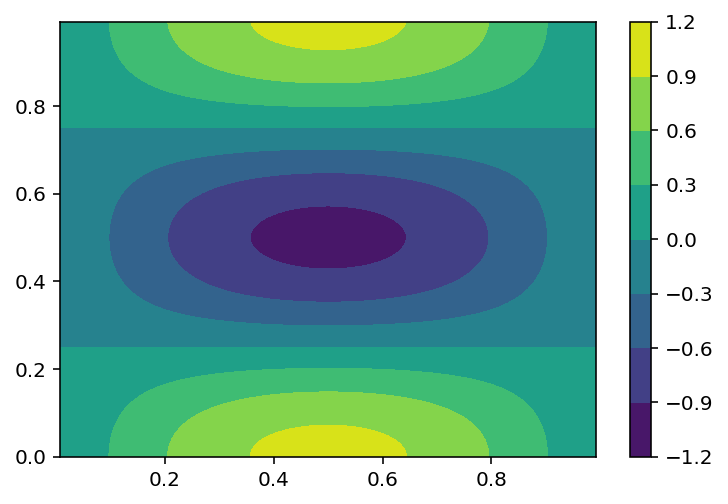

In [14]:
cs = plt.contourf(X,Y,U)
cb = plt.colorbar(cs)